# Continious Achitecture Analyzer CAA

This tool analyses external dependencies (connections and libraries) in a micro-service archicture system based on OpenFaas and Python 3.

Install script dependencies..

In [145]:
pip install -r requirements.txt 

Note: you may need to restart the kernel to use updated packages.


In [146]:
# notebook dependencies
import sys
import pathlib
from pathlib import Path
import re
import networkx as nx
import matplotlib.pyplot as plt

# Part 1: Analyze imports

The first part of the analysis with will to analyse the import statements to identify which libraires are required at runtime. 

The case study mentioned in the report is found in CODE_ROOT_FOLDER. 


In [147]:
# change to point to the right folder on your mahchine where you cloned the case study
CODE_ROOT_FOLDER = 'code/'

# And a helper function to construct
# the full path of a file by adding the CODE_ROOT_FOLDER
def full_path(file_name):
    return CODE_ROOT_FOLDER+file_name

Lets declare a few helper functions to parse the source code for data extraction.

In [148]:
def LOC(file):
    return sum([1 for line in open(file)])

In [149]:
def extract_import_from_line(line):
    x = re.search("^import (\S+)", line)
    if(x == None):
        x = re.search("^from (\S+)", line)

    return x.group(1)

def imports(file):
    # extracts all the imported modules from a file
    lines = [line for line in open(file)]
    
    all_imports = []
    for line in lines:
        try:
            all_imports.append(extract_import_from_line(line))
        except:
            continue
            
    return all_imports

assert "requests" in imports(full_path('iot-grafana-user-creator/handler.py'))

In [150]:
def module_from_file_path(folder_prefix, full_path):
    # extracting a module from a file name
    # e.g. /Users/mircea/Zeeguu-Core/zeeguu_core/model/user.py -> zeeguu_core.model.user
    
    file_name = full_path[len(folder_prefix):]
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    
    return file_name

def module(full_path):
    return module_from_file_path(CODE_ROOT_FOLDER, full_path)

assert 'iot-grafana-user-creator.handler' == module(full_path('iot-grafana-user-creator/handler.py'))

In [151]:
def dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")
    
    G = nx.Graph()

    for file in files:
        m = module(str(file))

        # Skip OpenFaas template files
        if "template" not in str(file):
            if m not in G.nodes:
                G.add_node(m)
            for each in imports(str(file)):
                G.add_edge(m, each)

    return G

In [152]:
def top_level_module(module_name, depth=1):
    # extracts the parent of depth X 
    # e.g. top_level_module(zeeguu_core.model.util, 1) -> zeeguu_core
    components = module_name.split(".")
    return ".".join(components[:depth])

assert (top_level_module("grafana-user-creator.helper") == "grafana-user-creator")
assert (top_level_module("grafana-user-creator.helper", 2) == "grafana-user-creator.helper")

In [153]:
def draw_graph_with_labels(G, figsize=(10,10)):
    plt.figure(figsize=figsize)
    nx.draw(G,with_labels=True)
    plt.show()

In [154]:
def system_module(m):
    return m.startswith('iot')

In [155]:
def abstracted_to_top_level_module(G):
    aG = nx.DiGraph()
    count = 0
    for each in G.edges():
        source = top_level_module(each[0])
        destination = top_level_module(each[1])
        if system_module(source) and system_module(destination):
            count = count + 1
            aG.add_edge(source, destination)
            
    if count == 0: 
        print()
        print("No dependencies amongst top level modules (prefix 'iot')")
        print()
        return None
    
    return aG

## Visualization: Imports

We visualize the imports as nodes in a graph, drawing an edge from service to library if the service contains the library

### Graph 1: Directed dependencies amongst internal top level modules

This graph shows dependencies amongst our own internal modules, if present

In [156]:
G = dependencies_graph()
aG = abstracted_to_top_level_module(G)
if(aG != None): 
    draw_graph_with_labels(aG, (5,5))


No dependencies amongst top level modules (prefix 'iot')




Due to this being microservice architecture, don't be alarmed with there is no graph above.




### Graph 2: Undirected dependencies amongst imports with weights

This graph shows dependencies amongst services and external libraries. Internal modules are represented with size based on LOC for that service.

In [157]:
def module_size(m):
    size = 0
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")
    for file in files:
        module_name = module(str(file))
        if module_name.startswith(m + '.'):
            size += LOC(str(file))
            
    return size

print("Lines of code pr service:")
print("iot-grafana-user-creator", module_size("iot-grafana-user-creator"))
print("iot-influxdb-savedata", module_size("iot-influxdb-savedata"))
print("iot-mqtt-interceptor", module_size("iot-mqtt-interceptor"))

Lines of code pr service:
iot-grafana-user-creator 101
iot-influxdb-savedata 86
iot-mqtt-interceptor 55


In [158]:
def draw_graph_with_weights(G, weight_function, figsize=(10,10)):
    node_weights = [weight_function(each)*10 for each in G.nodes]
    
    plt.figure(figsize=figsize)
    nx.draw(G,
            with_labels=True,
            node_size=node_weights)
    plt.show()

In [159]:
def abstracted_to_module(G):
    aG = nx.Graph()
    for each in G.edges():
        aG.add_edge(top_level_module(each[0]),
                    top_level_module(each[1]))

    return aG

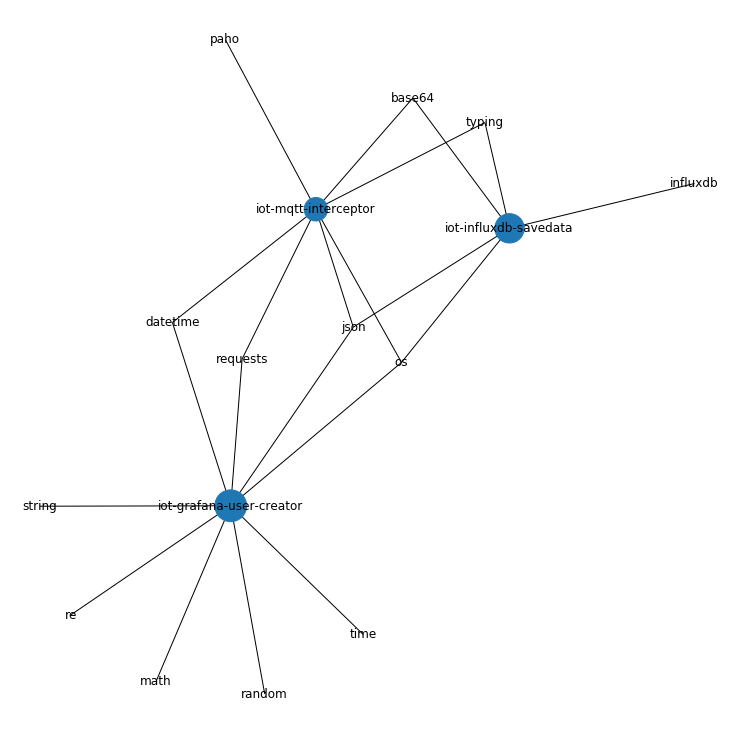

In [160]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_module(directed)
if(directedAbstracted != None): 
    draw_graph_with_weights(directedAbstracted, module_size, (10,10))

This diagram shows multiple things:

    The size of the micro service is imitiatly visible (for internal modules), so care can be taken if one grows too large

    Similar services are grouped together, if we deem serices similar if they have the same dependencis. The more semilar, the tighter they are grouped due to this actually being a chemistry representation, i wont go into detail.
    
    Shows our services, and the dependencies required to perform dynamic analysis.
    

### Graph 3: Directed dependencies amongst imports with weights

This graphs shows the direction of the dependencies in the previous graph

In [161]:
def dependencies_digraph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")
    
    G = nx.DiGraph()

    for file in files:
        m = module(str(file))

        if "template" not in str(file):
            if m not in G.nodes:
                G.add_node(m)
            for each in imports(str(file)):
                G.add_edge(m, each)

    return G

In [162]:
def abstracted_to_module_digraph(G):
    aG = nx.DiGraph()
    for each in G.edges():
        aG.add_edge(top_level_module(each[0]),
                    top_level_module(each[1]))

    return aG

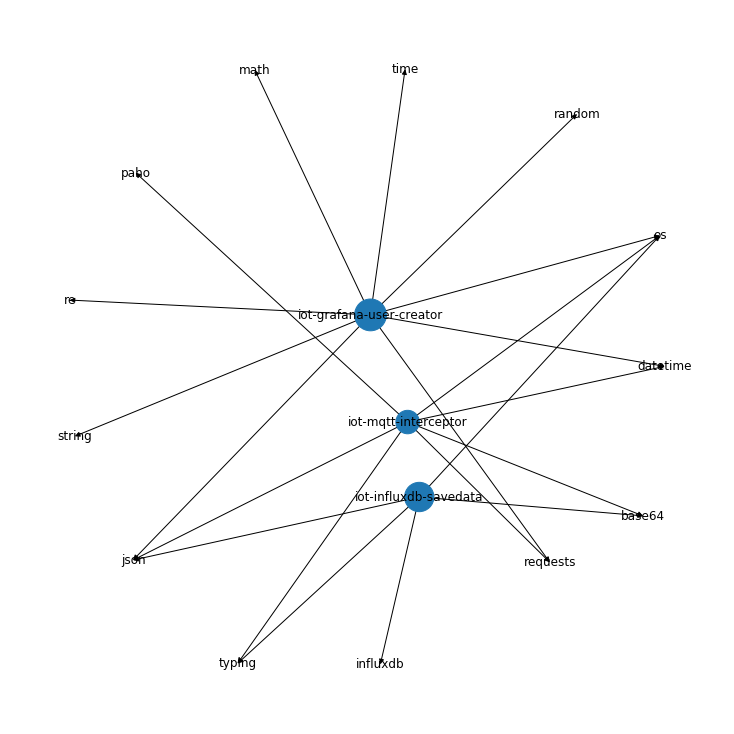

In [163]:
directed = dependencies_digraph()
directedAbstracted = abstracted_to_module_digraph(directed)
if(directedAbstracted != None): 
    draw_graph_with_weights(directedAbstracted, module_size, (10,10))

This diagram is also interresting, but less usefull than the undirected version.

This concludes the section in import analysis and visualization. We have identified and visualized the different dependencies required at compile time to compile the system. In the following section, we will take a look at the external services.

# Part 2: External services

In the following section we will determine the external dependencies of the services in the repository. 

A service is either a program running in a container, or a function as described in the report.

We are analying two types of services, all-ways on services running as typical docker containers and OpenFaas services. OpenFaas is as the name suggest a Function as a Service platform. 

The difference is how the environment variables are extracted from the infrastructure as code approach of that technology.

Common for both is that the script is using the python standard library 'os' to retrieve the environment variables, so substitution is very similiar.


## Analyzing OpenFaas functions

#### Environment variables 

In [164]:
def extract_env_from_line(line):
    x = re.search("(\w)*:(\w)*", line)
    if x != None: 
        var_name = line.split(": ")[0].strip()
        var_dec = line.split(": ")[1].strip()

    return (var_name, var_dec)

In [165]:
# replaces occourences of env_var with actual value
def map_env_vars_openfaas(handler, env_vars):
    print("Parsing", "'" + handler + "'", "and replacing variables...")
    lines = [line for line in open(handler)]
    
    all_vars = []
    for line in lines:
        try:
            for (k, v) in env_vars:
                if k in line:
                    print("Replacing", "os.getenv(\"" + k + "\")", "with", v)
                    line = line.replace("os.getenv(\"" + k + "\")", v, 1)
                
            all_vars.append(line)
        except:
            continue
            
    return all_vars

# find env_vars in the yml
def get_env_vars_openfaas(yml):
    print("Parsing", "'" + yml + "'", "for environment variables...")
    lines = [line for line in open(yml)]
    
    all_vars = []
    for line in lines:
        try:
            # skip attributes we don't care about for now
            if 'image' in line:
                continue
            if 'name' in line:
                continue
            if 'lang' in line:
                continue
            if 'handler' in line:
                continue
            if 'version' in line: 
                continue
                
            all_vars.append(extract_env_from_line(line))
            
        except:
            continue
        
    print("Environment variables:", all_vars)
    return all_vars

def get_program_text_with_env_openfaas(yml, handler):
    env_vars = get_env_vars_openfaas(full_path(yml))
    return map_env_vars_openfaas(full_path(handler), env_vars)


At this point the code contains the variables otherwise normally only obtianed at runtime. Lets see if we can figure out which external services the service is communicating with.

#### Replace environment variables in code, and extract correct values from code

In [166]:
def extract_url_from_line(line):
    # filter initial source code lines so only one with variables remains
    matching = re.search("(https?:\/\/(.)*)", line)
    
    if matching != None or 'ec2' in line: # not https?:// format, or contains ec2 for aws. 
        # line contais varaible with url
        
        var_name = line.split("=")[0].strip()
        var_dec = line.split("=")[1].strip()
        
        # refine if not composite variable
        if '+' not in line: 
            y = re.search("((https?:\/\/)?[-\w.]*(\.\w{2,3}(:?[\d]{2,6})?))", line)
            if y.group(1) != None: 
                var_dec = y.group(1)

        print("    >", var_name, var_dec)

    return (var_name, var_dec)

def find_external_services(program):
    lines = [line for line in program]
    
    services = []
    for line in lines:
        try:
            services.append(extract_url_from_line(line)) # extract lines with urls
        except:
            continue
    
    print()
    print("Found", len(services), "external services")
    return services


def interpret_service_strings(env_vars):
    # Interpretes the external services by substitution, and removes +, spaces and quotes.
    interpreted = []
    for line in env_vars:
        try:
            for (k, v) in env_vars:
                if k in line[1]:
                    print("Replacing", k, "with", v)
                    # clean up string
                    tmp = line[1].replace(k, v, 1)
                    tmp = tmp.strip().replace("'", "")
                    tmp = tmp.replace("+", "")
                    res = tmp.replace(" ", "")

            # only modified values
            interpreted.append((line[0], res))
            
        except:
            continue
            
    print("Changed", len(interpreted), "values by substitution", "\n")
    return interpreted


def analyse_external_services(yml, handler):
    ex_services_map = find_external_services(
        get_program_text_with_env_openfaas(
            yml, 
            handler))
    
    changed = interpret_service_strings(ex_services_map)
    
    # combine lists to one, or return env if no changes
    if len(changed) > 0:
        list1, list2 = zip(*changed)
        for(k,v) in ex_services_map:
            if k in list1:
                continue
            else: 
                changed.append((k, v))
        return changed

    else: 
        return ex_services_map


def analyze_grafana():
    print()
    print("Analysing IOT-Grafana-user-creator...\n")
    external_dependencies_grafana = analyse_external_services('iot-grafana-user-creator/iot-assignment2.yml', 'iot-grafana-user-creator/handler.py')
    print("Results for IOT-Grafana-user-creator:")
    for (k,v) in external_dependencies_grafana:
        print("  ", k+":", v)

    print()
    print()
    return external_dependencies_grafana

def analyze_influxdb():
    print()
    print("Analyzing IOT-InfluxDB-SaveData...\n")
    external_dependencies_influx = analyse_external_services('iot-influxdb-savedata/iot-assignment2.yml', 'iot-influxdb-savedata/handler.py')
    print("Results for IOT-InfluxDB-SaveData:")
    for (k,v) in external_dependencies_influx:
        print("  ", k+":", v)

    print()
    print()
    return external_dependencies_influx


external_dependencies_grafana = analyze_grafana()
print()
external_dependencies_influx = analyze_influxdb()


Analysing IOT-Grafana-user-creator...

Parsing 'code/iot-grafana-user-creator/iot-assignment2.yml' for environment variables...
Environment variables: [('gateway', 'https://gateway.christoffernissen.me'), ('host', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000')]
Parsing 'code/iot-grafana-user-creator/handler.py' and replacing variables...
Replacing os.getenv("host") with ec2-34-226-215-115.compute-1.amazonaws.com:3000
    > HOST ec2-34-226-215-115.compute-1.amazonaws.com:3000
    > URL_USERS 'http://admin:smartmeter@' + HOST + '/api/admin/users'
    > URL_DASHBOARD 'http://' + HOST + '/api/dashboards/db'
    > URL_DASHBOARD_PERMISSIONS 'http://' + HOST + '/api/dashboards/id/%s/permissions'
    > URL_CUSTOMERS_TEAM_MEMBERS 'http://' + HOST + '/api/teams/10/members'

Found 5 external services
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws.com:3000
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws.com:3000
Replacing HOST with ec2-34-226-215-115.compute-1.amazonaws

Now we have an overview of the OpenFaas functions. In the following section the same will be calculated for the docker container service MQTT-Interceptor. 

Finally, we will visualize the different services, and the links between services.

## Analyzing Docker service

In [167]:
def extract_env_from_line_docker(line):
    x = re.search("(\w)*=(\w)*", line)
    if x != None: 
        var_name = line.split("=")[0].strip()
        var_dec = line.split("=")[1].strip()

    return (var_name, var_dec)

In [168]:
def map_env_vars_docker(handler, env_vars):
    print("Parsing", "'" + handler + "'", "and replacing variables...")
    lines = [line for line in open(handler)]
    
    all_vars = []
    for line in lines:
        try:
            for (k, v) in env_vars:
                if k in line:
                    if 'os.getenv' in line: 
                        print("    Replacing", "os.getenv(\"" + k + "\")", "with", v)
                        line = line.replace("os.getenv(\"" + k + "\")", v, 1)
                    else: 
                        print("    Replacing", k, "with", v)
                        line = line.replace(k, v, 1)
                        line.replace("+", "")
                          
                all_vars.append(line)
        except:
            continue
            
    return all_vars


def get_env_vars_docker(env):
    print("Parsing", "'" + env + "'", "for environment variables...\n")
    lines = [line for line in open(env)]
    
    all_vars = []
    for line in lines:
        try:
            all_vars.append(extract_env_from_line_docker(line))
            
        except:
            continue
        
    print("Environment variables:\n", all_vars)
    return all_vars


def get_program_text_with_env_docker(env, code):
    env_vars = get_env_vars_docker(full_path(env))
    return map_env_vars_docker(full_path(code), env_vars)

At this point we have modified the source code so it now is substituted with env vars

In [169]:
def extract_urls_from_line_docker(line):
    # filter initial source code lines so only one with variables remains
    x = re.search("(https?:\/\/(.)*)", line)
    
    if x != None or 'ec2' in line: 
        var_name = line.split("=")[0].strip()
        var_dec = line.split("=")[1].strip()
        
        # refine if not composite variable
        if '+' not in line: 
            y = re.search("((https?:\/\/)?[-\w.]*(\.\w{2,3})(:[\d]{4})?)", line)
            if y.group(1) != None: 
                var_dec = y.group(1)
                
    return (var_name, var_dec.replace("+", " ").replace(" ", "").replace("\"", ""))


def find_external_services_docker(program):
    lines = [line for line in program]
    
    services = []
    for line in lines:
        try:
            services.append(extract_urls_from_line_docker(line))
        except:
            continue
    
    print()
    print("Found", len(services), "external services\n")
    return services


def analyse_external_services_docker(yml, handler):
    mod_program = get_program_text_with_env_docker(
            yml, 
            handler)
    
    return find_external_services_docker(mod_program)

def analyze_mqtt():
    print()
    print("IOT-MQTT-INTERCEPTOR")
    external_dependencies_mqtt = analyse_external_services_docker('iot-mqtt-interceptor/env_vars', 
                'iot-mqtt-interceptor/app.py')
    print("Results:")
    for (k,v) in external_dependencies_mqtt:
        print("  ", k+":", v)

    # now we have all external dependencies, including our own functions. Lets identify those:

    funcs = []
    print("Identified following dependencies on OpenFaas Functions")
    for (k,v) in external_dependencies_mqtt:
        if '/function/' in v:
            func = v.split("/")[len(v.split("/"))-1]
            print("  ", func)
            funcs.append(func)

    print()
    print()
    return external_dependencies_mqtt

external_dependencies_mqtt = analyze_mqtt()


IOT-MQTT-INTERCEPTOR
Parsing 'code/iot-mqtt-interceptor/env_vars' for environment variables...

Environment variables:
 [('gateway_url', 'https://gateway.christoffernissen.me')]
Parsing 'code/iot-mqtt-interceptor/app.py' and replacing variables...
    Replacing os.getenv("gateway_url") with https://gateway.christoffernissen.me
    Replacing os.getenv("gateway_url") with https://gateway.christoffernissen.me

Found 1 external services

Results:
   function_url: https://gateway.christoffernissen.me/function/iot-influxdb-savedata
Identified following dependencies on OpenFaas Functions
   iot-influxdb-savedata




Puhhh. Thats it. We have identified the external dependencies, and also identifed our functions. 
We can now use the information to graw diagrams. 


## Visualization of external dependencies

### Summary of analysis

In [170]:
# Uncomment for print lines with analysis results 

# analyze_grafana()
# analyze_influxdb()
# analyze_mqtt()

### Visualization Mapping Rules

In the analysis we found for each service, all variables that contains url structure values have been saved as key value pair. 

To draw an allocation draw of the micro service architecture and its external dependencies, the following mapping rules will be applied:

    Graph 4: 
        Services added as nodes, but external services are abstracted to top level uri identifier. 
        
        Edges are mapped from service -> external serive, labeled with the entire variable declaration (url)
      
    Graph 5:
        Each of our services will be added to the graph as nodes, with size indicating lines of code in service.

        For each service, the map of variable name / url is added as to the graph:
            - url will be added as new node, due to this indicating an external service.
            - variable name is used as label from service -> external service
                e.g variable InfluxDb = http://localhost would result in: service --'InfluxDb'--> localhost
        
        
        

In [171]:
def base_graph():
    # construct base graph consisting of internal modules. Should be applied to each system module
    G = nx.MultiDiGraph()
    
    G.add_node('iot-mqtt-interceptor')
    G.add_node('iot-influxdb-savedata')
    G.add_node('iot-grafana-user-creator')
    
    return G
    
labels = []
def dependencies_graph_with_functions(G, list, current_func):
    for (k, v) in list:
        if 'function' in v: 
            func = v.split("/")[len(v.split("/"))-1]
            
            # already there because base graph, add edge
            G.add_edge(current_func, func.lower())
            labels.append(((current_func, func.lower()), k))

        else:

            if k not in G.nodes:
                # extract common identifer from url. (top level external identifier)
                y = re.search("([\d\w-]*):?['.'][\w]{2,3}", v)
                #G.add_node(y.group())
                
                G.add_edge(current_func, y.group(), k)
                #G.add_edge(current_func, y.group()+v.split(y.group())[1])
                
                labels.append(((current_func, y.group()+v.split(y.group())[1]), k))
                
    return G
    
g0 = base_graph()
g1 = dependencies_graph_with_functions(g0, external_dependencies_mqtt, 'iot-mqtt-interceptor')
g2 = dependencies_graph_with_functions(g1, external_dependencies_grafana, 'iot-grafana-user-creator')
g3 = dependencies_graph_with_functions(g2, external_dependencies_influx, 'iot-influxdb-savedata')

### Graph 4: Directed weighted external dependencies

In [172]:
def draw_graph_with_weights_and_labels(G, weight_function, figsize=(10,10)):
    node_weights = [weight_function(each)*10 for each in G.nodes]
    
    plt.figure(figsize=figsize)
    
    print()
    print("Labels prepared, but couldnt insert in graph")
    print()
    print("Labels")
    print('format: (origin, destination) label')
    #print(labels)
    for (k,v) in labels:
        print(k, v)
    print()
    
    nx.draw(G,
            with_labels=True,
            edge_labels=labels,
            node_size=node_weights)
    


Labels prepared, but couldnt insert in graph

Labels
format: (origin, destination) label
('iot-mqtt-interceptor', 'iot-influxdb-savedata') function_url
('iot-grafana-user-creator', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/admin/users') URL_USERS
('iot-grafana-user-creator', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/dashboards/db') URL_DASHBOARD
('iot-grafana-user-creator', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/dashboards/id/%s/permissions') URL_DASHBOARD_PERMISSIONS
('iot-grafana-user-creator', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/teams/10/members') URL_CUSTOMERS_TEAM_MEMBERS
('iot-grafana-user-creator', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000') HOST
('iot-influxdb-savedata', 'ec2-34-226-215-115.compute-1.amazonaws.com') INFLUXDB_ADDRESS



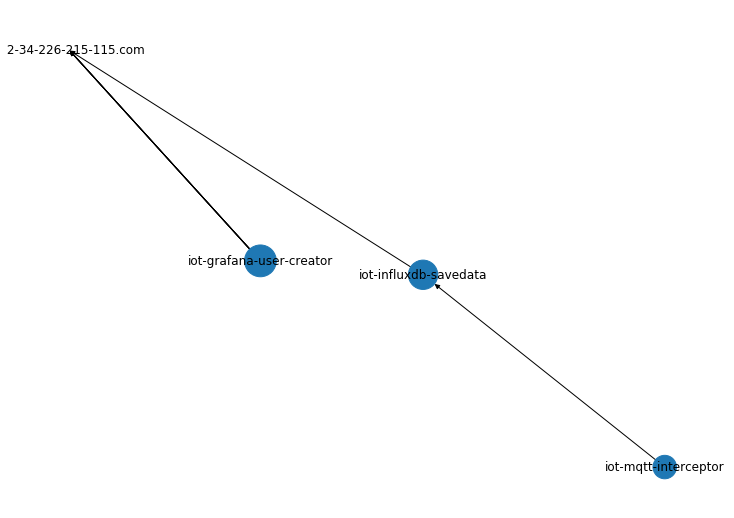

In [173]:
draw_graph_with_weights_and_labels(g3, module_size, (10,7))

High level allocation viewpoint of logical services
    
    Observe a chain with iot-mqtt-interceptor -> iot-influxdb-savedata -> INFLUXDB_ADDRESS
    
    External dependencies required at runtime

### Graph 5: All external communication. Individual endpoints mapped as nodes

In [184]:
labels = []
def dependencies_graph_with_functions_mod(G, list, current_func):
    for (k, v) in list:
        if 'function' in v: 
            func = v.split("/")[len(v.split("/"))-1]
            
            # already there because base graph, add edge
            G.add_edge(current_func, func.lower())
            labels.append(((current_func, func.lower()), k))

        else:
            if k not in G.nodes:
                # extract common identifer from url
                y = re.search("([\d\w-]*):?['.'][\w]{2,3}", v)

                G.add_edge(current_func, y.group()+v.split(y.group())[1])
                
                labels.append(((current_func, y.group()+v.split(y.group())[1]), k))
                
    return G
    
g0 = base_graph()
g1 = dependencies_graph_with_functions_mod(g0, external_dependencies_mqtt, 'iot-mqtt-interceptor')
g2 = dependencies_graph_with_functions_mod(g1, external_dependencies_grafana, 'iot-grafana-user-creator')
g3 = dependencies_graph_with_functions_mod(g2, external_dependencies_influx, 'iot-influxdb-savedata')

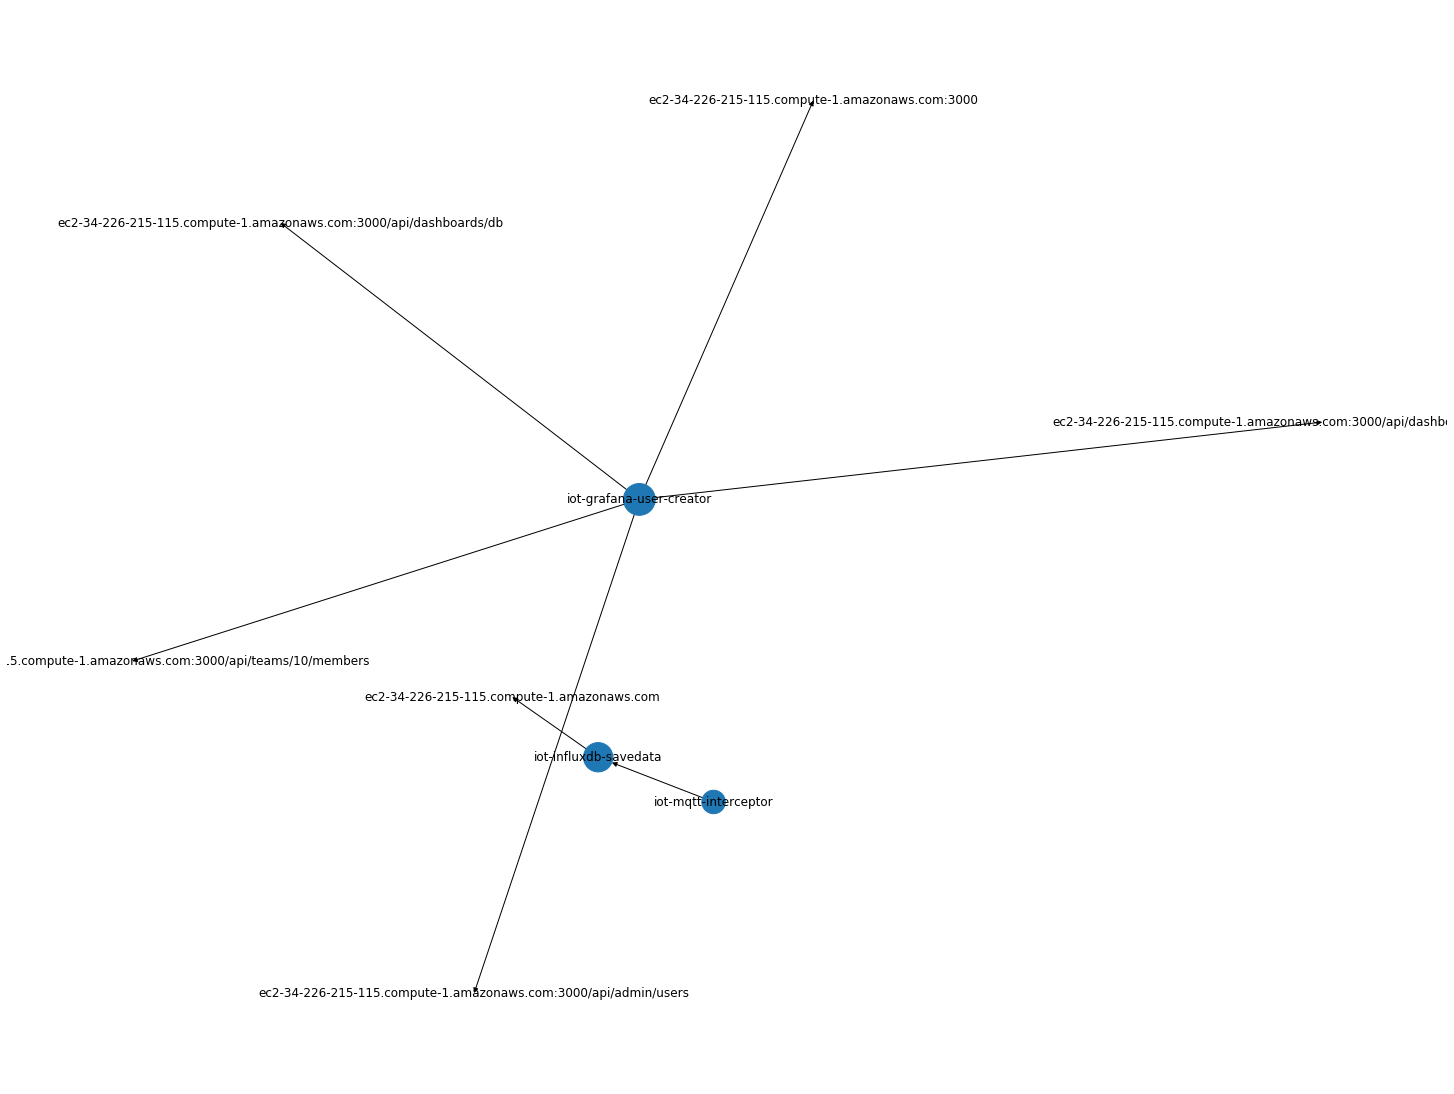

In [185]:
draw_graph_with_weights(g3, module_size, (20,15))

### Graph 6: All external communication. Nodes are top level identifier, with multiple edges idendicating communication paths

For this graph, we will use a simple graphwiz graph instead of the networkxx graphs used previously.

Edges in graph: 

(iot-mqtt-interceptor, iot-influxdb-savedata) with label function_url shown as [0] in diagram
(iot-grafana-user-creator, ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/admin/users) with label URL_USERS shown as [1] in diagram
(iot-grafana-user-creator, ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/dashboards/db) with label URL_DASHBOARD shown as [2] in diagram
(iot-grafana-user-creator, ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/dashboards/id/%s/permissions) with label URL_DASHBOARD_PERMISSIONS shown as [3] in diagram
(iot-grafana-user-creator, ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/teams/10/members) with label URL_CUSTOMERS_TEAM_MEMBERS shown as [4] in diagram
(iot-grafana-user-creator, ec2-34-226-215-115.compute-1.amazonaws.com:3000) with label HOST shown as [5] in diagram
(iot-influxdb-savedata, ec2-34-226-215-115.compute-1.amazonaws.com) with label INFLUXDB_ADDRESS shown as [6] in diagram

Graph:



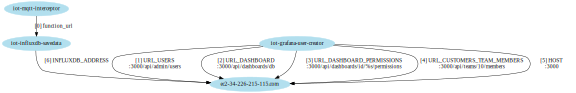

In [186]:
from graphviz import Digraph

g = Digraph(node_attr={'color': 'lightblue2', 'style': 'filled'})

g.attr(size='8,20')

print("Edges in graph: ")
print()

c = 0
for ((k,v),w) in labels:
    print("("+k+", "+v+")", "with label", w, "shown as", "["+str(c)+"]", "in diagram")
    
    y = re.search("([\d\w-]*):?['.'][\w]{2,3}", v)
    if y:
        
        #y.group()+v.split(y.group())[1]
        g.node(y.group())
        g.edge(k, y.group(), "[" + str(c) + "] "+ w + "    " + 
               "\n     " + v[len(v.split(":")[0]):] + "                ") #extra padding for readable label

    else: 
        # functions
        g.edge(k, v, "[" + str(c) + "] "+ w )
        
        
    c = c + 1
        
print()
print("Graph:")
print()

# show graph in jupyter
g

The final graph shows which services communcate with which other servers. If the url of the target contains additional information such as port or api endpoints, these are shown on in the edge label.

The crux of this graph is usability is the varible names in the code. 

The upside is that besides proper naming conventions, no further modification of the code is required to run this tool on a micro service architecture utilizing OpenFaas and Python 3.

Althrough the graphwiz graph above is not a UML-Diagram, this is our allocation viewpoint in terms of logical services in the system. This tool does not analyze which machines the services are running on, since container orchestrators decides this on runtime due to a variaity of conditions.


# Summary: Graphs

## Import graphs

### Graph 1: Directed dependencies amongst internal top level modules

In [187]:
G = dependencies_graph()
aG = abstracted_to_top_level_module(G)
if(aG != None): 
    draw_graph_with_labels(aG, (5,5))


No dependencies amongst top level modules (prefix 'iot')



### Graph 2: Undirected dependencies amongst imports with weights

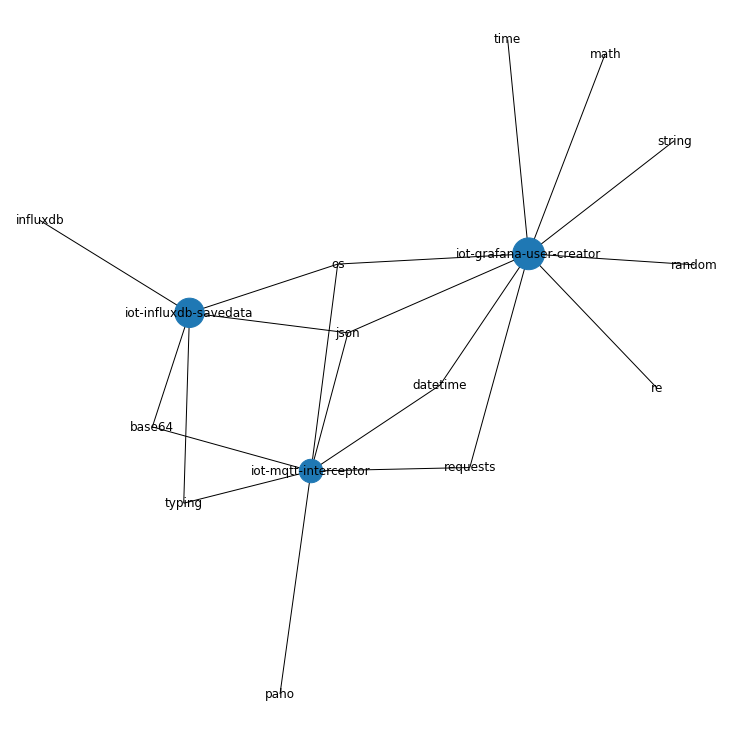

In [188]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_module(directed)
if(directedAbstracted != None): 
    draw_graph_with_weights(directedAbstracted, module_size, (10,10))

### Graph 3: Directed dependencies amongst imports with weights

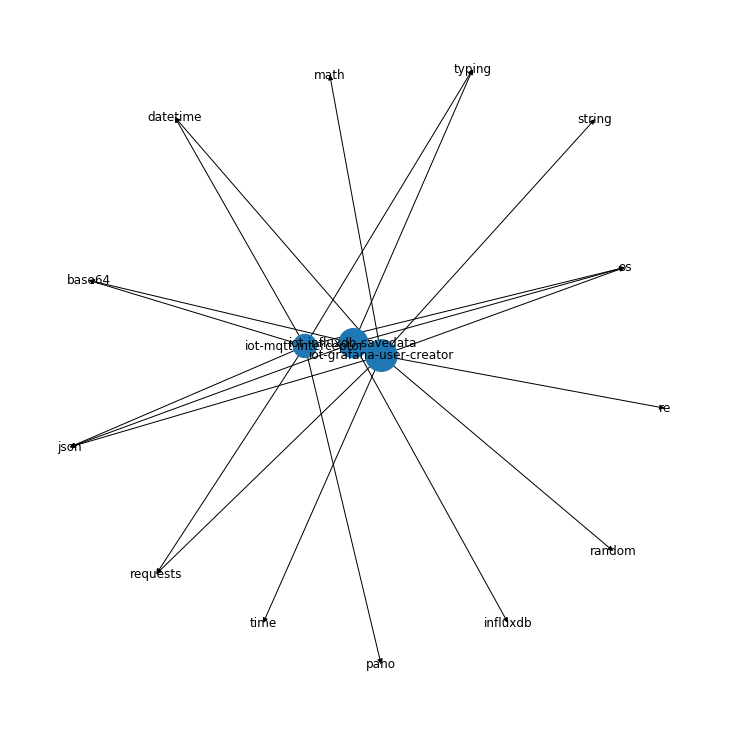

In [189]:
directed = dependencies_digraph()
directedAbstracted = abstracted_to_module_digraph(directed)
if(directedAbstracted != None): 
    draw_graph_with_weights(directedAbstracted, module_size, (10,10))

## External communication graphs

Undirected with weights 

Directed with weights. Each endpoint mappend to own node. 

Missing: Directed with each machine has node, but multiple communication links between each.



### Graph 4: Directed weighted external dependencies top level identifier


Labels prepared, but couldnt insert in graph

Labels
format: (origin, destination) label
('iot-mqtt-interceptor', 'iot-influxdb-savedata') function_url
('iot-grafana-user-creator', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/admin/users') URL_USERS
('iot-grafana-user-creator', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/dashboards/db') URL_DASHBOARD
('iot-grafana-user-creator', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/dashboards/id/%s/permissions') URL_DASHBOARD_PERMISSIONS
('iot-grafana-user-creator', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/teams/10/members') URL_CUSTOMERS_TEAM_MEMBERS
('iot-grafana-user-creator', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000') HOST
('iot-influxdb-savedata', 'ec2-34-226-215-115.compute-1.amazonaws.com') INFLUXDB_ADDRESS
('iot-mqtt-interceptor', 'iot-influxdb-savedata') function_url
('iot-grafana-user-creator', 'ec2-34-226-215-115.compute-1.amazonaws.com:3000/api/admin/users') URL_USERS
('iot-grafana-user-

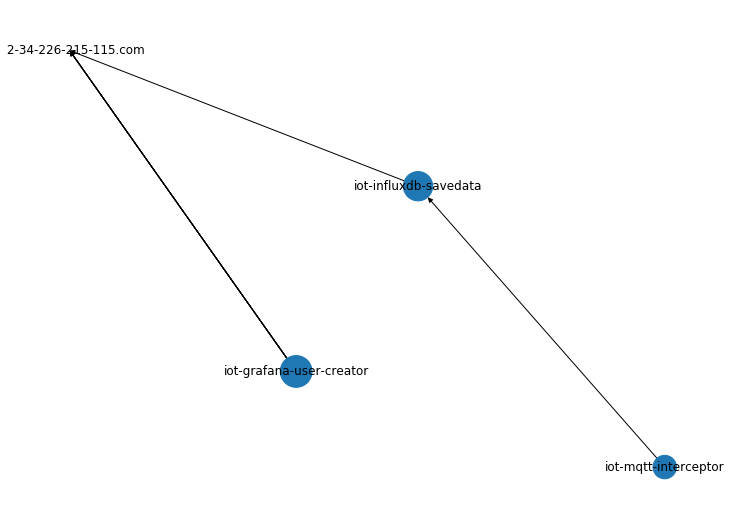

In [190]:
g_0 = base_graph()
g_1 = dependencies_graph_with_functions(g_0, external_dependencies_mqtt, 'iot-mqtt-interceptor')
g_2 = dependencies_graph_with_functions(g_1, external_dependencies_grafana, 'iot-grafana-user-creator')
g_3 = dependencies_graph_with_functions(g_2, external_dependencies_influx, 'iot-influxdb-savedata')
draw_graph_with_weights_and_labels(g_3, module_size, (10,7))

### Graph 5: All external communication. Individual endpoints mapped as nodes

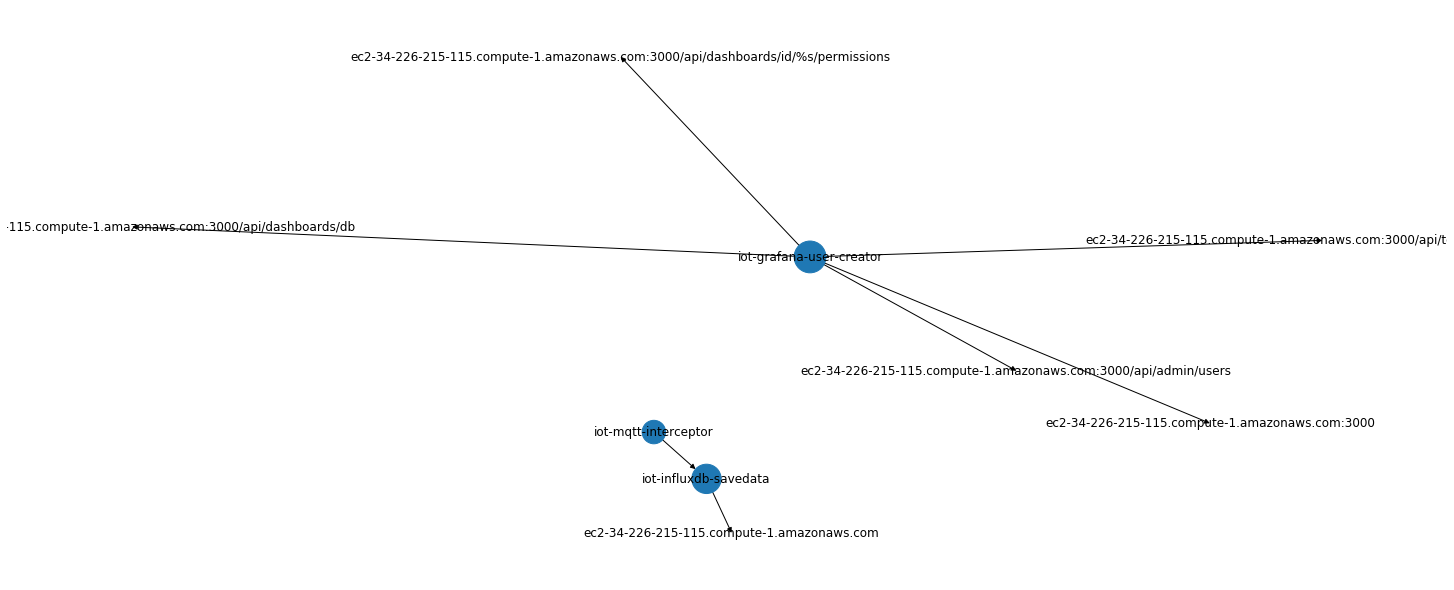

In [191]:
_g0 = base_graph()
_g1 = dependencies_graph_with_functions_mod(_g0, external_dependencies_mqtt, 'iot-mqtt-interceptor')
_g2 = dependencies_graph_with_functions_mod(_g1, external_dependencies_grafana, 'iot-grafana-user-creator')
_g3 = dependencies_graph_with_functions_mod(_g2, external_dependencies_influx, 'iot-influxdb-savedata')
draw_graph_with_weights(_g3, module_size, (20,8))

### Graph 6: All external communication. Nodes are top level identifier, with multiple edges idendicating communication paths

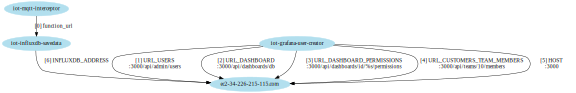

In [192]:
g

# Future work


* Implement environment variable analysis for different languages

* Investigate more involved lexical parsing for larger systems

* Integrate with version-control system to upload notebook to Wiki section of repository
